<a href="https://colab.research.google.com/github/Sarah-neuro/neuron/blob/main/LIF_Neuron_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Leaky Integrate-and-Fire (LIF) Neuron Simulation**
The notebook simulates how a neuron behaves by integrating input signals and firing when a particular threshold is attained while also accounting for membrane leakage.



##Objectives

1. Simulate the LIF Model.
2. Integrate extrenal inputs with LIF neuron like DC and GWN current.
3. Study the different output signals attained.

##Set-Up

In [27]:
#Imports
import numpy as np
import matplotlib.pyplot as plt

##Model Parameters

- *Simulation time (T):* total duration in milliseconds  
- *Time step (dt):* resolution of a simulation  
- *Membrane time constant (tau):* speed in which the neuron’s voltage decays towards rest  
- *Input current (I):* external current injected to the neuron  
- *Threshold (V_th):* voltage level at which LIF neuron fires a spike  
- *Reset potential (V_reset):* voltage after spike reset  
- *Resting potential (V_rest):* baseline membrane voltage  

##Plotting Settings

In [28]:
## Plot Trajectory of Menbrane Trajectory of a Single Neuron
def plot_volt_record(pars, v, sp):
  V_th, dt, range_t = pars['V_th'], pars['dt'], pars['range_t']

  #for better visualization of spikes
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 15

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])

## Plot of Gaussian White Noise (GWN) Input and Neuronal Output
def plot_GWN(pars, I_GWN):
  plt.figure(figsize=(12, 4))
  # GWN current input Subplot
  plt.subplot(121)
  plt.plot(pars['range_t'][::3], I_GWN[::3], 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$I_{GWN}$ (pA)')
  # neron response subplot
  plt.subplot(122)
  plot_volt_record(pars, v, sp)
  plt.tight_layout()


## The Leaky Integrate and Fire (LIF) Model


 LIF model is a simplified mathematical model which integrates the input over time with a leakage, much like an RC circuit. If the integrated value exceeds a threshold, then the LIF neuron emits a voltage spike. The LIF neuron is simply treated as a discrete event. This is because instead of encoding information in the shape or form of each spike, the model relies solely on the timing or frequency of spikes to convey information.

###Application of LIF Model

The subthreshold membrane potential dynamics of a LIF neuron is described by

\begin{eqnarray}
C_m\frac{dV}{dt} = -g_L(V-E_L) + I,\quad (1)
\end{eqnarray}

where $C_m$ is the membrane capacitance, $V$ is the membrane potential, $g_L$ is the leak conductance ($g_L = 1/R$, the inverse of the leak resistance $R$), $E_L$ is the resting potential, and $I$ is the external input current.

Dividing both sides of the above equation by $g_L$ gives

\begin{align}
\tau_m\frac{dV}{dt} = -(V-E_L) + \frac{I}{g_L}\,,\quad (2)
\end{align}

where the $\tau_m$ is membrane time constant and is defined as $\tau_m=C_m/g_L$.

Below, we will use Eqn.(2) to simulate LIF neuron dynamics.

If $I$ is sufficiently strong such that $V$ reaches a certain threshold value $V_{\rm th}$, $V$ is reset to a reset potential $V_{\rm reset}< V_{\rm th}$, and voltage is clamped to $V_{\rm reset}$ for $\tau_{\rm ref}$ ms, mimicking the refractoriness of the neuron during an action potential:

\begin{eqnarray}
\mathrm{if}\quad V(t_{\text{sp}})\geq V_{\rm th}&:& V(t)=V_{\rm reset} \text{  for } t\in(t_{\text{sp}}, t_{\text{sp}} + \tau_{\text{ref}}]
\end{eqnarray}
where $t_{\rm sp}$ is the spike time when $V(t)$ just exceeded $V_{\rm th}$.
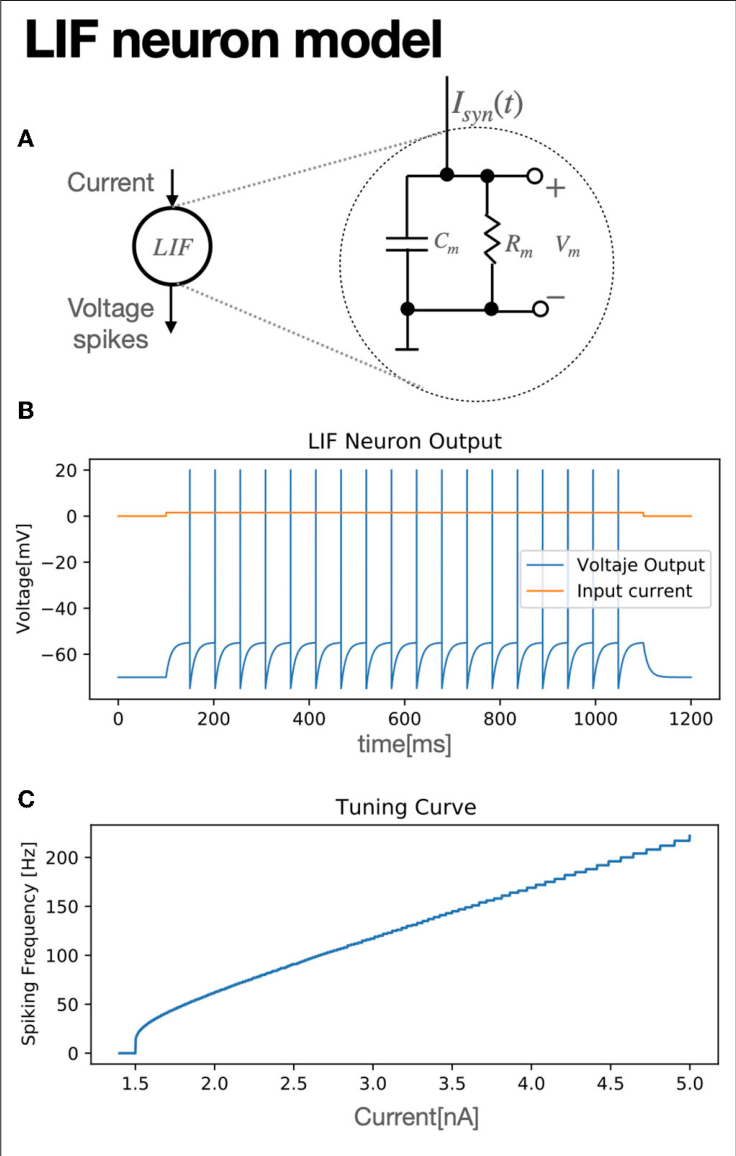

###Python Code

In [29]:
def default_pars(**kwargs):
  pars = {}

  # neuron parameters #
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()

###Python Simulation of LIF Model with External Input Current
 Simulate the Leaky Integrate-and-Fire (LIF) neuron model.

    Parameters:
    - pars : dictionary containing model and simulation parameters
    - Iinj : injected current (pA), either constant or array-like
    - stop : if True, use a finite-duration pulse current

    Returns:
    - v : membrane potential trace
    - rec_spikes : list of spike times (ms)

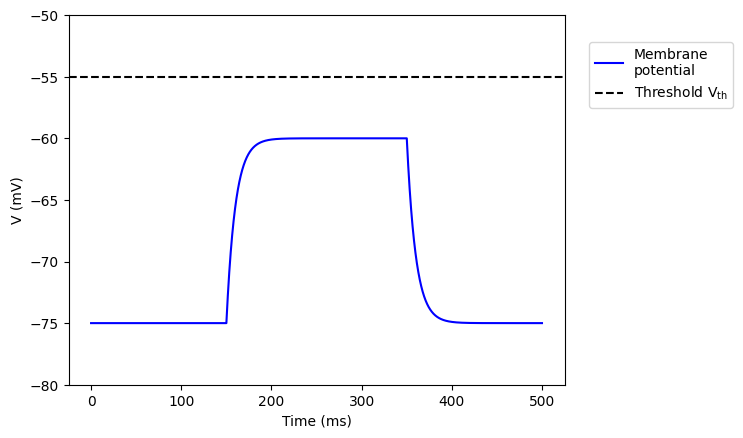

In [30]:
def run_LIF(pars, Iinj=100, stop=False):

    # Extraction of parameters
    V_th, V_reset, tau_m, g_L, V_init, E_L, dt, tref, t_range  = pars['V_th'], pars['V_reset'], pars['tau_m'], pars['g_L'], pars['V_init'], pars['E_L'], pars['dt'], pars['tref'], pars['range_t']

    Lt = len(t_range)

    # Starting voltage recording and input current
    v = np.zeros(Lt)           # Creating an array to hold membrane potential at each time step
    v[0] = V_init              # Setting the initial membrane potential
    Iinj = Iinj * np.ones(Lt)  # Creating an array of input current, constant at all time steps

    if stop:
        # Inject current only for a middle chunk of time to simulate neurons responding to brief input
        Iinj[:Lt // 2 - 1000] = 0
        Iinj[Lt // 2 + 1000:] = 0

    # Variable for refractory tracking #
    tr = 0
    rec_spikes = []

    # Simulation loop of LIF #
    for it in range(Lt - 1):
        if tr > 0:  # when the neuron is in its refractory period
            v[it] = V_reset
            v[it + 1] = V_reset
            tr = tr - 1
        elif v[it] >= V_th:  # Spiking of neuron
            rec_spikes.append(it * dt)  # Store spike time (ms)
            v[it] = V_reset
            v[it + 1] = V_reset
            tr = int(tref / dt)  # Set refractory time (in steps)
        else:  # Computing voltage build ip using Euler's method when its neither refraction nor firing
            dv = (-(v[it] - E_L) + Iinj[it] / g_L) * (dt / tau_m)
            v[it + 1] = v[it] + dv
    return v, np.array(rec_spikes)


# Example case: #
pars = default_pars(T=500)
v, sp = run_LIF(pars, Iinj=150, stop=True)
plot_volt_record(pars, v, sp)
plt.ylim([-80, -50])
plt.show()

###Output of LIF Model to different Inputs

####1.Direct Current (DC)

Voltage response of LIF neuron with respect to DC input of 300pA

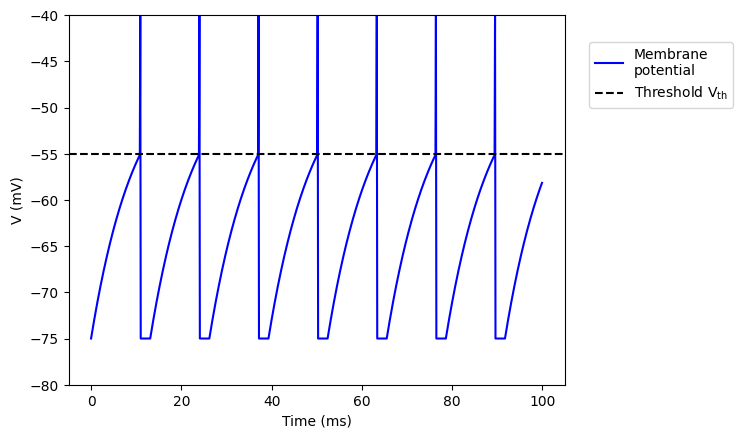

In [31]:
pars = default_pars(T=100)  # get the parameters

# Run the model to obtain v and sp
v, sp = run_LIF(pars, Iinj=300)

plot_volt_record(pars, v, sp)
plt.show()

####2.Gaussian white noise (GWN) current

In an _in vivo_ system, neurons have a variety of inputs, and it diplays a random nature with time variability.

We mimic this by incorporating Gaussian white noise (GWN) $\xi(t)$ with mean

\begin{eqnarray}
E[\xi(t)]=\mu=0,
\end{eqnarray}

and autocovariance
\begin{eqnarray}
E[\xi(t)\xi(t+\tau)]=\sigma_\xi^2 \delta(\tau)
\end{eqnarray}

GWN has a mean of zero, meaning it only captures random changes in input to a neuron. But, real neurons also receive a steady input. To reflect this, we can add a constant value
𝜇 to the noise.

#####Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

#####Returns:
    I          : Gaussian white noise input

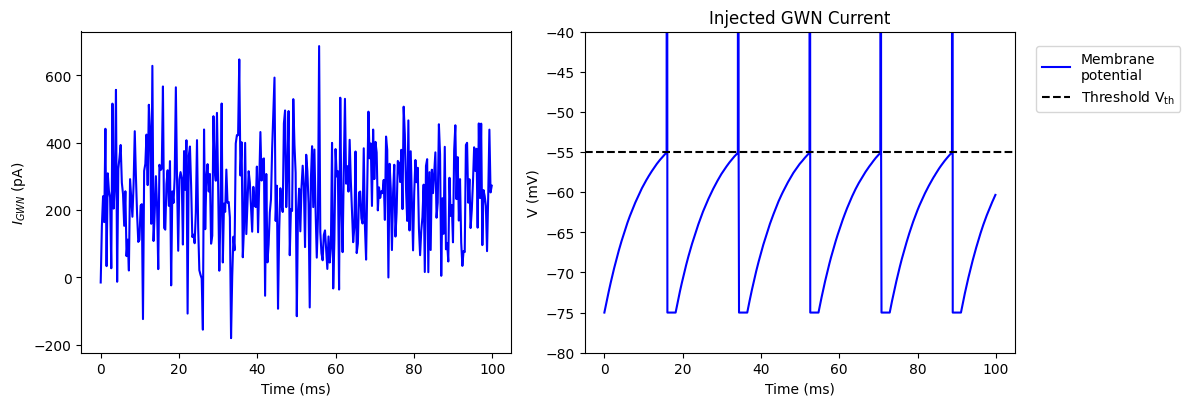

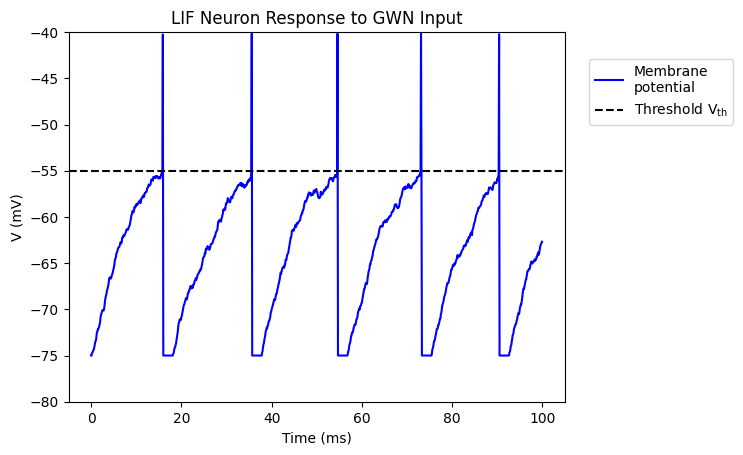

In [40]:
def my_GWN(pars, mu, sigma, myseed=False):
    if myseed:
        np.random.seed(myseed)
    dt = pars['dt']
    Lt = len(pars['range_t'])
    I_GWN = mu + sigma * np.random.randn(Lt)
    return I_GWN


# === Main Simulation === #
pars = default_pars(T=100.)
sig_gwn = 150.         # Noise amplitude
mu_gwn = 250.        # Mean input current

# Generate GWN input
I_GWN = my_GWN(pars, mu=mu_gwn, sigma=sig_gwn, myseed=2020)

# Run the LIF model with GWN
v_gwn, sp_gwn = run_LIF(pars, Iinj=I_GWN)  # Make sure run_LIF accepts `Iinj=`

# Plot injected current for visualization
plot_GWN(pars, I_GWN)
plt.title("Injected GWN Current")
plt.show()

# Plot LIF response to GWN
plot_volt_record(pars, v_gwn, sp_gwn)
plt.title("LIF Neuron Response to GWN Input")
plt.show()


## Credits & References

*   The educational material is inspired by content from Neuromatch Academy (NMA). All rights and acknowledgments belong to the original authors and contributors of the NMA curriculum.
*   Image Reference:
LIF model: (A) Diagram of a spiking LIF neuron. (B) Spiking activity for a LIF neuron...
Source: https://www.researchgate.net/figure/LIF-model-A-diagram-of-a-spiking-LIF-neuron-B-Spiking-activity-for-a-LIF-neuron_fig1_360731602


